In [1]:
#@title  1. Import các thư viện cần thiết

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import glob # Để tìm file theo pattern
from sklearn.model_selection import train_test_split # Để chia train/test
from PIL import Image

# (Tùy chọn) Tắt thông báo oneDNN nếu muốn
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [2]:
#@title 2. Cấu hình và Tải dữ liệu từ Google Drive (nếu có)

# Nếu bạn tải dữ liệu lên Google Drive, bạn cần mount Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Cấu hình cho dữ liệu chữ ký ---
# THAY ĐỔI ĐƯỜNG DẪN NÀY cho phù hợp với vị trí dữ liệu của bạn trên Google Drive
# Ví dụ: nếu thư mục SIGNATURES của bạn nằm trong My Drive/Colab Notebooks/SIGNATURES
BASE_DATA_DIR = '/content/drive/MyDrive/SIGNATURES' # <<=== THAY ĐỔI ĐƯỜNG DẪN NÀY
# Hoặc nếu bạn tải file zip lên Colab và giải nén:
# !unzip -q path_to_your_zip_file.zip -d /content/data
# BASE_DATA_DIR = '/content/data/SIGNATURES' # Ví dụ


# Tên thư mục con chứa chữ ký giả và thật
FORG_FOLDER_NAME = 'full_forg'
ORG_FOLDER_NAME = 'full_org'

# Kích thước chuẩn hóa cho ảnh đầu vào (64x256)
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 256
CHANNELS = 1      # Ảnh xám

# Số lượng mẫu xử lý trong một lần cập nhật trọng số.
BATCH_SIZE = 32
VALIDATION_SPLIT_RATIO = 0.2 # Tỷ lệ dữ liệu dùng cho kiểm định.
SEED = 42 # Để đảm bảo kết quả lặp lại

# Kiểm tra xem BASE_DATA_DIR có tồn tại không
if not os.path.isdir(BASE_DATA_DIR):
    print(f"LỖI: Thư mục BASE_DATA_DIR '{BASE_DATA_DIR}' không tồn tại!")
    print("Vui lòng kiểm tra lại đường dẫn hoặc tải dữ liệu lên và giải nén.")
    # Dừng ở đây nếu không có dữ liệu
    raise FileNotFoundError(f"Thư mục BASE_DATA_DIR '{BASE_DATA_DIR}' không tồn tại.")
else:
    print(f"Sử dụng BASE_DATA_DIR: {BASE_DATA_DIR}")

Mounted at /content/drive
Sử dụng BASE_DATA_DIR: /content/drive/MyDrive/SIGNATURES


In [3]:
#@title 3. Thu thập đường dẫn file và trích xuất nhãn

all_image_paths = []
all_writer_ids_str = [] # Lưu ID người viết dưới dạng string trước

folders_to_scan = [os.path.join(BASE_DATA_DIR, FORG_FOLDER_NAME),
                   os.path.join(BASE_DATA_DIR, ORG_FOLDER_NAME)]

print(f"Đang quét các thư mục: {folders_to_scan}")

# Tìm tất cả các file ảnh (.png, .tif, .jpg) trong thư mục.
for folder_path in folders_to_scan:
    if not os.path.isdir(folder_path):
        print(f"CẢNH BÁO: Không tìm thấy thư mục {folder_path}. Bỏ qua.")
        continue
    image_files = glob.glob(os.path.join(folder_path, '*.png'))
    if not image_files:
        image_files = glob.glob(os.path.join(folder_path, '*.tif'))
    if not image_files:
        image_files = glob.glob(os.path.join(folder_path, '*.jpg'))

    print(f"Tìm thấy {len(image_files)} file trong {folder_path}")

    for img_path in image_files:
        filename = os.path.basename(img_path)
        parts = filename.split('_')
        if len(parts) >= 2:
          # Trích xuất ID người viết
            writer_id_str = parts[1]
            all_image_paths.append(img_path)
            all_writer_ids_str.append(writer_id_str)
        else:
            print(f"CẢNH BÁO: Không thể trích xuất ID người viết từ tên file: {filename}")

if not all_image_paths:
    print("LỖI: Không tìm thấy file ảnh nào. Vui lòng kiểm tra lại đường dẫn và cấu trúc thư mục.")
    # Dừng ở đây nếu không có dữ liệu
    raise FileNotFoundError("Không tìm thấy file ảnh nào.")
else:
    print(f"Tổng số ảnh tìm thấy: {len(all_image_paths)}")
    print(f"Ví dụ 5 đường dẫn ảnh đầu tiên: {all_image_paths[:5]}")
    print(f"Ví dụ 5 ID người viết (string) đầu tiên: {all_writer_ids_str[:5]}")

Đang quét các thư mục: ['/content/drive/MyDrive/SIGNATURES/full_forg', '/content/drive/MyDrive/SIGNATURES/full_org']
Tìm thấy 1320 file trong /content/drive/MyDrive/SIGNATURES/full_forg
Tìm thấy 1392 file trong /content/drive/MyDrive/SIGNATURES/full_org
Tổng số ảnh tìm thấy: 2712
Ví dụ 5 đường dẫn ảnh đầu tiên: ['/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_24_6.png', '/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_16_17.png', '/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_17_21.png', '/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_25_18.png', '/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_25_24.png']
Ví dụ 5 ID người viết (string) đầu tiên: ['24', '16', '17', '25', '25']


In [4]:
#@title 4. Xử lý nhãn và chia dữ liệu

# Tạo danh sách các ID người viết duy nhất và đã được sắp xếp. Đây chính là các "lớp" mà mô hình cần phân loại.
class_names = sorted(list(set(all_writer_ids_str)))

# Số lượng người viết (số lớp).
num_classes = len(class_names)

if num_classes == 0:
    print("LỖI: Không có lớp (người viết) nào được tìm thấy. Kiểm tra lại quá trình trích xuất ID.")
    raise ValueError("Không có lớp (người viết) nào được tìm thấy.")
else:
    print(f"Tìm thấy {num_classes} lớp (người viết): {class_names}")

# Tạo một từ điển ánh xạ ID người viết (chuỗi) sang nhãn số nguyên (0, 1, 2,...). Mô hình học máy thường làm việc tốt hơn với nhãn số.
writer_id_to_int_label = {writer_id: i for i, writer_id in enumerate(class_names)}

# Chuyển đổi tất cả ID người viết dạng chuỗi sang dạng số nguyên.
all_labels_int = [writer_id_to_int_label[writer_id] for writer_id in all_writer_ids_str]

print(f"Ví dụ 5 nhãn số nguyên đầu tiên: {all_labels_int[:5]}")


'''
.	train_test_split: Chia dữ liệu (all_image_paths và all_labels_int) thành tập huấn luyện (train_) và tập kiểm định (val_) theo tỷ lệ VALIDATION_SPLIT_RATIO.
.	random_state=SEED: Đảm bảo chia nhất quán.
.	stratify=all_labels_int: Quan trọng! Đảm bảo tỷ lệ các lớp (người viết) trong tập huấn luyện và tập kiểm định là tương đương nhau. Điều này rất hữu ích khi dữ liệu mất cân bằng.
'''

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels_int,
    test_size=VALIDATION_SPLIT_RATIO,
    random_state=SEED,
    stratify=all_labels_int
)


print(f"Số lượng mẫu huấn luyện: {len(train_paths)}")
print(f"Số lượng mẫu kiểm định: {len(val_paths)}")

Tìm thấy 58 lớp (người viết): ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '6', '7', '8', '9']
Ví dụ 5 nhãn số nguyên đầu tiên: [16, 7, 8, 17, 17]
Số lượng mẫu huấn luyện: 2169
Số lượng mẫu kiểm định: 543


In [5]:
#@title 5. Hàm tải và tiền xử lý ảnh

# Hàm nhận đường dẫn ảnh và nhãn.
def load_and_preprocess_image(path, label):
    try:
      # Đọc nội dung file ảnh.
        image_bytes = tf.io.read_file(path)
        # Giải mã byte ảnh thành tensor. Có xử lý lỗi nếu định dạng không phải PNG hoặc JPEG.
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        # Thay đổi kích thước ảnh về IMAGE_HEIGHT, IMAGE_WIDTH. (64x256)
        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)

        # Chuẩn hóa giá trị pixel về khoảng [0, 1]. Đây là bước quan trọng để mô hình hội tụ tốt hơn.
        image = tf.cast(image, tf.float32) / 255.0

        # Trả về image (tensor) và label.
        return image, label
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {path}: {e}")
        return None, label

In [6]:
#@title 6. Tạo tf.data.Dataset

AUTOTUNE = tf.data.AUTOTUNE # Di chuyển định nghĩa AUTOTUNE ra ngoài hàm để sử dụng chung

'''
1.	AUTOTUNE = tf.data.AUTOTUNE: Cho phép TensorFlow tự động điều chỉnh số lượng luồng xử lý song song để tối ưu hiệu suất pipeline dữ liệu.
2.	tf.data.Dataset.from_tensor_slices: Tạo một đối tượng Dataset từ các mảng đường dẫn và nhãn.
3.	train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE): Áp dụng hàm load_and_preprocess_image cho từng cặp (đường dẫn, nhãn) trong dataset. num_parallel_calls tăng tốc quá trình này.
4.	train_dataset.filter(lambda x, y: x is not None): Loại bỏ các mẫu bị lỗi trong quá trình map (khi load_and_preprocess_image trả về None).
5.	train_dataset.shuffle(buffer_size=len(train_paths), seed=SEED): (Chỉ cho tập train) Xáo trộn dữ liệu để tránh mô hình học theo thứ tự. buffer_size nên đủ lớn.
6.	train_dataset.batch(BATCH_SIZE): Nhóm các mẫu thành các batch.
7.	train_dataset.prefetch(buffer_size=AUTOTUNE): Cho phép pipeline dữ liệu chuẩn bị sẵn các batch tiếp theo trong khi mô hình đang xử lý batch hiện tại, giúp giảm thời gian chờ I/O.
8.	Lặp lại quy trình cho cả train_dataset và val_dataset.

'''

# Huấn luyện
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.filter(lambda x, y: x is not None)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths), seed=SEED)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Kiểm định
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.filter(lambda x, y: x is not None)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("Tạo Dataset hoàn tất.")

Tạo Dataset hoàn tất.


In [7]:
#@title 7. Xây dựng mô hình CNN

# Tạo một mô hình tuần tự, nơi các lớp được xếp chồng lên nhau.

'''
Lớp Conv2D (Convolutional Layer): Conv2D(32, (3, 3), activation='relu', input_shape=(...)): Lớp tích chập đầu tiên với 32 bộ lọc, kích thước kernel 3x3, hàm kích hoạt ReLU. input_shape chỉ cần định nghĩa ở lớp đầu tiên.
  -> Các lớp Conv2D tiếp theo (64, 128 bộ lọc) cũng tương tự, học các đặc trưng ngày càng phức tạp.
Lớp MaxPooling2D:MaxPooling2D((2, 2)): Giảm kích thước không gian của feature map (lấy giá trị lớn nhất trong cửa sổ 2x2), giúp giảm số lượng tham số và kiểm soát overfitting.
Lớp Flatten:Flatten(): Chuyển đổi feature map 2D (hoặc 3D) thành một vector 1D để có thể đưa vào các lớp Dense.
Lớp Dense (Fully Connected Layer):Dense(128, activation='relu'): Lớp kết nối đầy đủ với 128 units, hàm kích hoạt ReLU.
Lớp Dropout: Dropout(0.5): Một kỹ thuật điều chuẩn (regularization) quan trọng. Trong quá trình huấn luyện, nó ngẫu nhiên "tắt" 50% các unit ở lớp trước đó, giúp mô hình tránh học thuộc dữ liệu huấn luyện (overfitting) và tổng quát hóa tốt hơn.
Lớp Output (Dense): Dense(num_classes): Lớp output với số unit bằng num_classes (số người viết). Không có hàm kích hoạt ở đây vì chúng ta sẽ sử dụng from_logits=True trong hàm loss.

'''

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes) # Không cần activation='softmax' ở đây nếu dùng from_logits=True
])

# In ra cấu trúc chi tiết của mô hình (số lớp, số tham số mỗi lớp,...).
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 254, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 30, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,949,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049,402 (11.63 MB)

 Trainable params: 3,049,402 (11.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#@title 8. Compile mô hình

'''
1.	model.compile(): Cấu hình quá trình học cho mô hình.
2.	optimizer='adam': Chọn thuật toán tối ưu Adam. Adam là một lựa chọn phổ biến, hiệu quả và thường không cần tinh chỉnh nhiều.
3.	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True):
 -> SparseCategoricalCrossentropy: Hàm mất mát phù hợp cho bài toán phân loại đa lớp khi nhãn là số nguyên (0, 1, 2,...).
 -> from_logits=True: Chỉ định rằng output của mô hình là logits (giá trị thô trước softmax). Điều này ổn định hơn về mặt số học so với việc thêm lớp Softmax rồi dùng loss không có from_logits.
4.	metrics=['accuracy']: Theo dõi độ chính xác (accuracy) trong quá trình huấn luyện và đánh giá.

'''
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print("Compile mô hình hoàn tất.")

Compile mô hình hoàn tất.


In [9]:
#@title 9. Huấn luyện mô hình

epochs = 10 # Giảm số epochs để chạy thử nhanh hơn, sau đó bạn có thể tăng lên

'''
train_dataset: Dữ liệu huấn luyện (đã được tạo bằng tf.data).
validation_data=val_dataset: Dữ liệu kiểm định, dùng để đánh giá hiệu suất của mô hình trên dữ liệu chưa từng thấy sau mỗi epoch.
epochs=epochs: Số epoch đã định nghĩa.

'''

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)
# Lưu lại lịch sử huấn luyện (loss, accuracy trên tập train và val qua từng epoch)

Epoch 1/10
     68/Unknown 275s 54ms/step - accuracy: 0.0146 - loss: 4.0813

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


68/68 ━━━━━━━━━━━━━━━━━━━━ 329s 863ms/step - accuracy: 0.0146 - loss: 4.0811 - val_accuracy: 0.0184 - val_loss: 4.0590
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.0161 - loss: 4.0594 - val_accuracy: 0.0166 - val_loss: 4.0491
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.0287 - loss: 4.0210 - val_accuracy: 0.1657 - val_loss: 3.4722
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.1099 - loss: 3.4868 - val_accuracy: 0.3720 - val_loss: 2.6421
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.2166 - loss: 2.9340 - val_accuracy: 0.4807 - val_loss: 2.2041
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.2908 - loss: 2.5248 - val_accuracy: 0.5764 - val_loss: 1.7272
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.3509 - loss: 2.2232 - val_accuracy: 0.6556 - val_loss: 1.4612
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.3948 - loss: 2.0252 - val_accuracy: 0.7053 - v

17/17 - 3s - 183ms/step - accuracy: 0.7716 - loss: 1.0199
Độ chính xác trên tập kiểm định: 0.7716


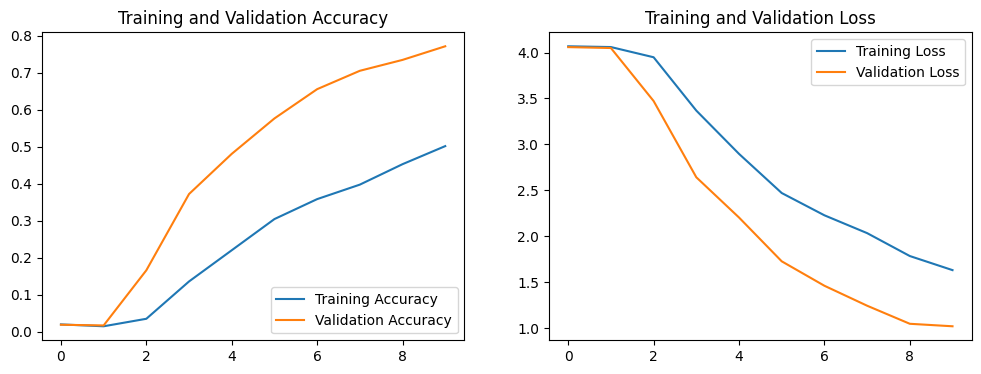

In [10]:
#@title 10. Đánh giá và Vẽ biểu đồ

# Đánh giá mô hình lần cuối trên tập kiểm định, trả về loss và accuracy.
test_loss, cnn_test_acc = model.evaluate(val_dataset, verbose=2)
print(f"Độ chính xác trên tập kiểm định: {cnn_test_acc:.4f}")

# Trích xuất accuracy, val_accuracy, loss, val_loss từ đối tượng history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


'''
Sử dụng matplotlib.pyplot để vẽ hai biểu đồ:
->	Độ chính xác huấn luyện và kiểm định qua các epoch.
->  Giá trị mất mát huấn luyện và kiểm định qua các epoch.

'''

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# @title 11. Lưu mô hình

model_save_path = os.path.join(BASE_DATA_DIR, 'signature_writer_identification_model.keras') # Lưu ở định dạng .keras mới

# Định nghĩa đường dẫn và tên file để lưu mô hình.
model.save(model_save_path)
print(f"Mô hình đã được lưu tại: {model_save_path}")

# Hoặc lưu ở định dạng HDF5 cũ nếu muốn
model_save_path_h5 = os.path.join(BASE_DATA_DIR, 'signature_writer_identification_model.h5')
model.save(model_save_path_h5)
print(f"Mô hình đã được lưu tại: {model_save_path_h5}")


'''
Định dạng .keras (mới, được khuyến nghị).
Định dạng .h5 (HDF5, cũ hơn nhưng vẫn phổ biến).

'''

Mô hình đã được lưu tại: /content/drive/MyDrive/SIGNATURES/signature_writer_identification_model.keras
Mô hình đã được lưu tại: /content/drive/MyDrive/SIGNATURES/signature_writer_identification_model.h5


'\nĐịnh dạng .keras (mới, được khuyến nghị).\nĐịnh dạng .h5 (HDF5, cũ hơn nhưng vẫn phổ biến).\n\n'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Ảnh này được dự đoán là của người viết: 58 với độ tự tin 51.52%


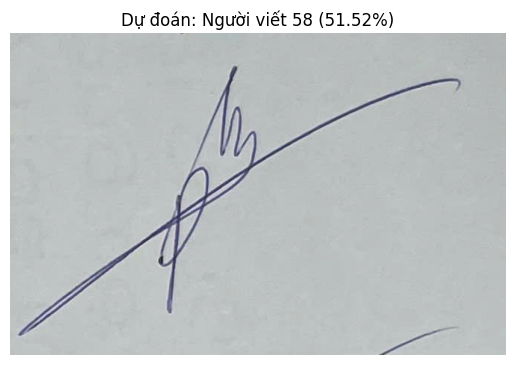

In [15]:
#@title 12: Dự đoán trên ảnh mới (test từng mẫu)

'''
Hàm này tương tự như load_and_preprocess_image nhưng được điều chỉnh
cho một ảnh đơn lẻ và thêm tf.expand_dims để tạo batch size là 1 (vì mô hình mong đợi đầu vào dạng batch).
'''

def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path} để dự đoán: {e}")
        return None

# Ví dụ sử dụng:
# Cần tải ảnh lên Google Drive hoặc Colab session nếu làm trên Google Colab
new_signature_path = '/content/drive/MyDrive/SIGNATURES/full_org/original_58_1.png' # <<=== THAY ĐỔI ĐƯỜNG DẪN NÀY
if os.path.exists(new_signature_path):

    # Tải và tiền xử lý ảnh mới.
    preprocessed_img_for_pred = preprocess_single_image_for_prediction(new_signature_path)
    if preprocessed_img_for_pred is not None:

        # Đưa ảnh đã xử lý vào mô hình để nhận dự đoán. Kết quả là một mảng các logits (hoặc probabilities nếu lớp cuối có softmax).
        predictions = model.predict(preprocessed_img_for_pred)

        # Áp dụng hàm softmax để chuyển logits thành xác suất cho mỗi lớp.
        score = tf.nn.softmax(predictions[0])

        # Tìm chỉ số của lớp có xác suất cao nhất.
        predicted_class_index = np.argmax(score)

        # Lấy tên ID người viết tương ứng từ chỉ số đó.
        predicted_writer_id = class_names[predicted_class_index]

        # Tính độ tự tin của dự đoán.
        confidence = 100 * np.max(score)

        print(f"Ảnh này được dự đoán là của người viết: {predicted_writer_id} với độ tự tin {confidence:.2f}%")

        # Hiển thị ảnh và kết quả dự đoán.
        img_display = Image.open(new_signature_path)
        plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
        plt.title(f"Dự đoán: Người viết {predicted_writer_id} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()
else:
    print(f"Không tìm thấy ảnh tại: {new_signature_path}")

Sẽ kiểm tra 10 ảnh từ tập validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Ảnh: forgeries_41_16.png
  Nhãn thực tế: Người viết 41
  Dự đoán: Người viết 41 (Độ tự tin: 17.41%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ảnh: original_9_1.png
  Nhãn thực tế: Người viết 9
  Dự đoán: Người viết 9 (Độ tự tin: 81.53%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ảnh: original_17_10.png
  Nhãn thực tế: Người viết 17
  Dự đoán: Người viết 17 (Độ tự tin: 95.20%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ảnh: original_37_14.png
  Nhãn thực tế: Người viết 37
  Dự đoán: Người viết 33 (Độ tự tin: 35.82%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ảnh: original_18_5.png
  Nhãn thực tế: Người viết 18
  Dự đoán: Người viết 18 (Độ tự tin: 18.12%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Ảnh: forgeries_11_11.png
  Nhãn thực tế: Người viết 11
  Dự đoán: Người viết 11 (Độ tự t

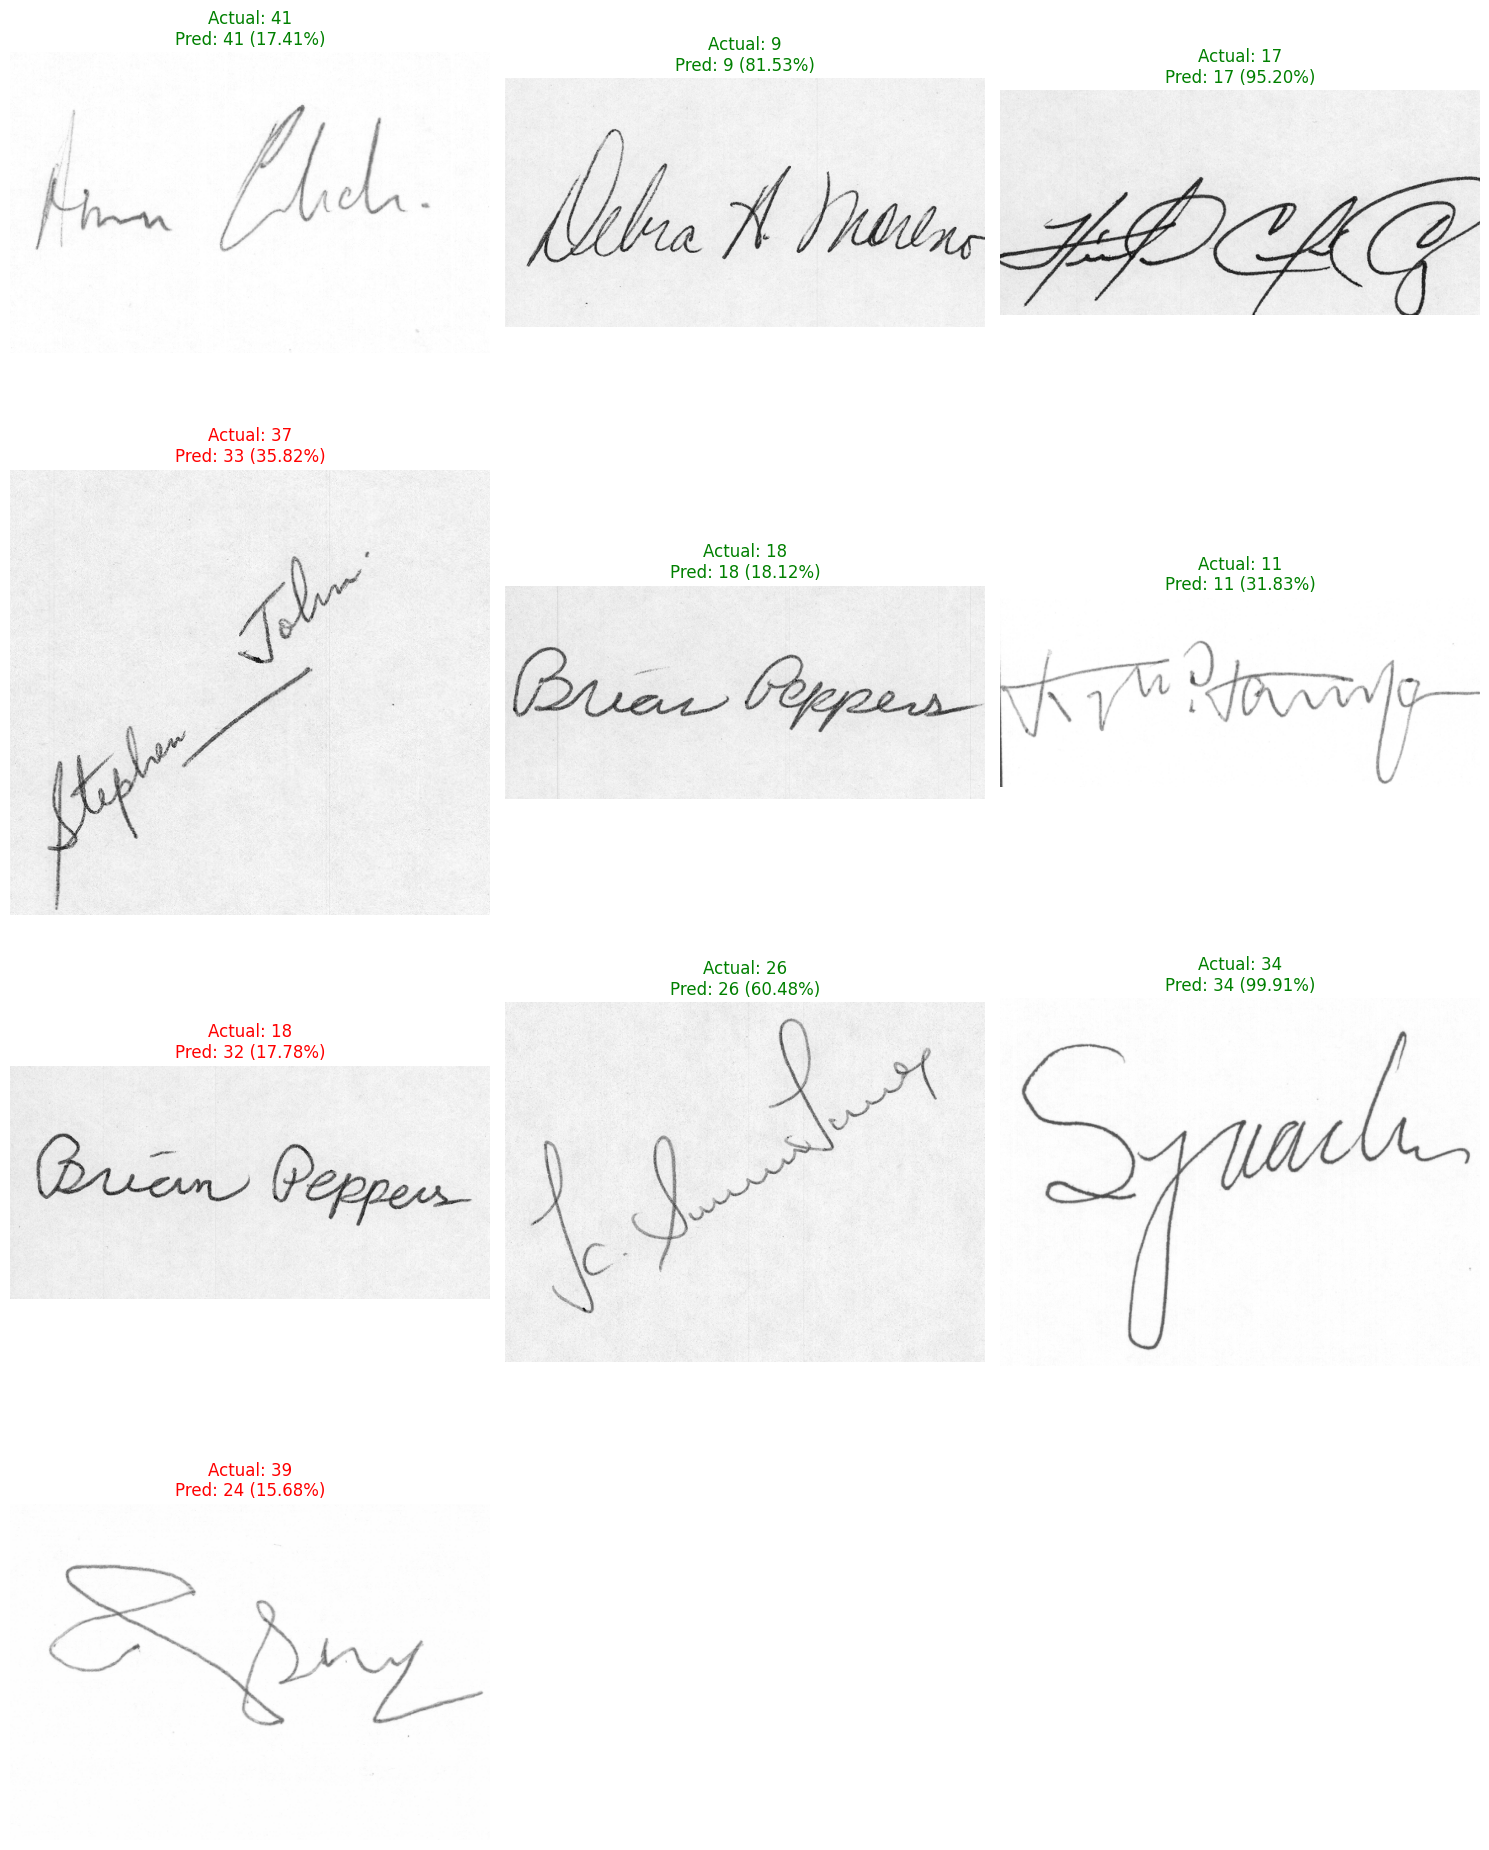

In [13]:
#@title 13: Dự đoán trên nhiều ảnh (test hàng loạt)

# (Giữ nguyên hàm preprocess_single_image_for_prediction)
def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path} để dự đoán: {e}")
        return None

'''
--- Danh sách các ảnh bạn muốn kiểm tra ---
Bạn có thể tạo danh sách này theo nhiều cách:
1. Liệt kê thủ công:
test_image_paths = [
    '/content/drive/MyDrive/SIGNATURES/full_org/original_52_1.png',
    '/content/drive/MyDrive/SIGNATURES/full_forg/forgeries_1_10.png',
    # Thêm các đường dẫn khác vào đây
]
'''


'''
2. Lấy một vài ảnh ngẫu nhiên từ tập validation (val_paths đã có từ trước)
Hoặc tạo một tập test riêng biệt và quét thư mục đó.
Ở đây, chúng ta sẽ lấy một vài ảnh từ val_paths làm ví dụ.
Đảm bảo ô code chứa val_paths đã được chạy.
'''

if 'val_paths' in locals() and len(val_paths) > 0:
    num_test_samples = min(10, len(val_paths)) # Kiểm tra tối đa 10 ảnh từ tập validation

    # np.random.seed(SEED) # Để lấy mẫu ngẫu nhiên nhất quán

    test_image_paths_indices = np.random.choice(len(val_paths), num_test_samples, replace=False)
    test_image_paths = [val_paths[i] for i in test_image_paths_indices]
    actual_labels_for_test = [class_names[val_labels[i]] for i in test_image_paths_indices] # Lấy nhãn thực tế
    print(f"Sẽ kiểm tra {len(test_image_paths)} ảnh từ tập validation.")
else:
    print("Không tìm thấy 'val_paths' hoặc 'val_paths' rỗng. Vui lòng cung cấp danh sách ảnh test thủ công.")
    test_image_paths = [] # Để tránh lỗi nếu không có val_paths
    actual_labels_for_test = []


# --- Lặp qua từng ảnh để dự đoán và hiển thị ---
if test_image_paths:
    num_images_to_display = len(test_image_paths)
    # Tính toán số hàng và cột cho subplot dựa trên số lượng ảnh
    # Ví dụ: nếu có 6 ảnh, tạo lưới 2x3 hoặc 3x2
    cols = 3 # Số cột mong muốn
    rows = (num_images_to_display + cols - 1) // cols # Tính số hàng cần thiết

    plt.figure(figsize=(5 * cols, 5 * rows)) # Điều chỉnh kích thước tổng thể

    for i, image_path in enumerate(test_image_paths):
        if not os.path.exists(image_path):
            print(f"Bỏ qua: Không tìm thấy ảnh tại {image_path}")
            continue

        preprocessed_img = preprocess_single_image_for_prediction(image_path)

        if preprocessed_img is not None:
            predictions = model.predict(preprocessed_img)
            score = tf.nn.softmax(predictions[0])
            predicted_class_index = np.argmax(score)
            predicted_writer_id = class_names[predicted_class_index]
            confidence = 100 * np.max(score)

            actual_writer_id = actual_labels_for_test[i] if actual_labels_for_test else "N/A"

            print(f"Ảnh: {os.path.basename(image_path)}")
            print(f"  Nhãn thực tế: Người viết {actual_writer_id}")
            print(f"  Dự đoán: Người viết {predicted_writer_id} (Độ tự tin: {confidence:.2f}%)")
            print("-" * 30)

            # Hiển thị ảnh và kết quả
            plt.subplot(rows, cols, i + 1)
            img_display = Image.open(image_path)
            plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
            title_text = f"Actual: {actual_writer_id}\nPred: {predicted_writer_id} ({confidence:.2f}%)"


            # Đổi màu tiêu đề (ví dụ: xanh lá cho dự đoán đúng, đỏ cho dự đoán sai) để dễ dàng nhận biết.
            title_color = 'green' if actual_writer_id == predicted_writer_id else 'red'
            plt.title(title_text, color=title_color)
            plt.axis('off')
        else:
            print(f"Bỏ qua: Không thể xử lý ảnh {image_path}")

    plt.tight_layout() # Điều chỉnh khoảng cách giữa các subplot
    plt.show()
else:
    print("Không có ảnh nào trong danh sách 'test_image_paths' để kiểm tra.")

In [16]:
#@title 14: Dự đoán trên toàn bộ chữ ký của một người viết cụ thể

# (Giữ nguyên hàm preprocess_single_image_for_prediction)
def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path} để dự đoán: {e}")
        return None

# --- Chọn ID người viết bạn muốn kiểm tra ---
TARGET_WRITER_ID_STR = '58' # <<=== THAY ĐỔI ID NGƯỜI VIẾT NÀY (ví dụ: '1', '56', '57', '58')

# --- Lọc ra tất cả ảnh của TARGET_WRITER_ID_STR ---
# Đảm bảo các biến all_image_paths, all_writer_ids_str, và class_names đã được định nghĩa từ các ô trước.
if 'all_image_paths' in locals() and 'all_writer_ids_str' in locals() and 'class_names' in locals():
    test_image_paths = []
    actual_labels_for_test = [] # Nhãn thực tế (dưới dạng string ID)

    # Kiểm tra xem TARGET_WRITER_ID_STR có trong class_names không
    if TARGET_WRITER_ID_STR not in class_names:
        print(f"LỖI: ID người viết '{TARGET_WRITER_ID_STR}' không được tìm thấy trong danh sách lớp (class_names).")
        print(f"Các ID người viết có sẵn: {class_names}")
    else:
        for i, writer_id_str_from_list in enumerate(all_writer_ids_str):
            if writer_id_str_from_list == TARGET_WRITER_ID_STR:
                test_image_paths.append(all_image_paths[i])
                actual_labels_for_test.append(writer_id_str_from_list) # Nhãn thực tế chính là TARGET_WRITER_ID_STR

        if test_image_paths:
            print(f"Tìm thấy {len(test_image_paths)} ảnh của người viết ID '{TARGET_WRITER_ID_STR}' để kiểm tra.")
            # Sắp xếp theo tên file để có thứ tự nhất quán (original rồi forgeries, hoặc theo số thứ tự mẫu)
            test_image_paths.sort()
            # actual_labels_for_test sẽ giống nhau cho tất cả, nên không cần sắp xếp theo nó.
        else:
            print(f"Không tìm thấy ảnh nào của người viết ID '{TARGET_WRITER_ID_STR}'.")
else:
    print("LỖI: Các biến 'all_image_paths', 'all_writer_ids_str', hoặc 'class_names' chưa được định nghĩa.")
    print("Vui lòng chạy các ô code trước đó để khởi tạo chúng.")
    test_image_paths = []
    actual_labels_for_test = []


# --- Lặp qua từng ảnh để dự đoán và hiển thị ---
if test_image_paths:
    num_images_to_display = len(test_image_paths)
    cols = 4 # Có thể tăng số cột nếu có nhiều ảnh (ví dụ 24 mẫu thì 4 cột x 6 hàng hoặc 6 cột x 4 hàng)
    rows = (num_images_to_display + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows + 1)) # Điều chỉnh kích thước, +1 cho suptitle

    correct_predictions = 0

    for i, image_path in enumerate(test_image_paths):
        if not os.path.exists(image_path):
            print(f"Bỏ qua: Không tìm thấy ảnh tại {image_path}")
            continue

        preprocessed_img = preprocess_single_image_for_prediction(image_path)

        if preprocessed_img is not None:
            predictions = model.predict(preprocessed_img, verbose=0) # verbose=0 để không in log của predict
            score = tf.nn.softmax(predictions[0])
            predicted_class_index = np.argmax(score)
            predicted_writer_id = class_names[predicted_class_index]
            confidence = 100 * np.max(score)

            actual_writer_id = actual_labels_for_test[i] # Đây sẽ luôn là TARGET_WRITER_ID_STR

            # In thông tin ra console (có thể comment bớt nếu quá nhiều)
            # print(f"Ảnh: {os.path.basename(image_path)}")
            # print(f"  Nhãn thực tế: Người viết {actual_writer_id}")
            # print(f"  Dự đoán: Người viết {predicted_writer_id} (Độ tự tin: {confidence:.2f}%)")
            # print("-" * 30)

            if actual_writer_id == predicted_writer_id:
                correct_predictions += 1

            # Hiển thị ảnh và kết quả
            plt.subplot(rows, cols, i + 1)
            img_display = Image.open(image_path)
            plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
            title_text = f"Actual: {actual_writer_id}\nPred: {predicted_writer_id} ({confidence:.2f}%)"
            title_color = 'green' if actual_writer_id == predicted_writer_id else 'red'
            plt.title(title_text, color=title_color, fontsize=8) # Giảm fontsize nếu cần
            plt.axis('off')
        else:
            print(f"Bỏ qua: Không thể xử lý ảnh {image_path}")

    overall_accuracy_for_target = (correct_predictions / num_images_to_display) * 100 if num_images_to_display > 0 else 0
    plt.suptitle(f"Dự đoán cho Người viết ID: {TARGET_WRITER_ID_STR} - Độ chính xác: {overall_accuracy_for_target:.2f}% ({correct_predictions}/{num_images_to_display})", fontsize=14, y=1.02) # y > 1 để tiêu đề không đè lên subplot
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh rect để chừa không gian cho suptitle
    plt.show()

    print(f"\nTổng kết cho người viết ID '{TARGET_WRITER_ID_STR}':")
    print(f"  Số lượng ảnh kiểm tra: {num_images_to_display}")
    print(f"  Số dự đoán đúng: {correct_predictions}")
    print(f"  Độ chính xác: {overall_accuracy_for_target:.2f}%")

else:
    print(f"Không có ảnh nào được tìm thấy cho người viết ID '{TARGET_WRITER_ID_STR}' để kiểm tra.")

Output hidden; open in https://colab.research.google.com to view.